## 라이브러리 불러오기

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from sklearn.neighbors import BallTree
from haversine import haversine, Unit

In [2]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

## Data load

In [3]:
data_path: str = "~/house/data"
train_data: pd.DataFrame = pd.read_csv(os.path.join(data_path, "train.csv"))
test_data: pd.DataFrame = pd.read_csv(os.path.join(data_path, "test.csv"))
sample_submission: pd.DataFrame = pd.read_csv(os.path.join(data_path, "sample_submission.csv"))

In [4]:
# 금리, 지하철, 학교, 공원 정보 불러오기
interest_data: pd.DataFrame = pd.read_csv(os.path.join(data_path, "interestRate.csv"))
subway_data: pd.DataFrame = pd.read_csv(os.path.join(data_path, "subwayInfo.csv"))
school_data: pd.DataFrame = pd.read_csv(os.path.join(data_path, "schoolinfo.csv"))
park_data: pd.DataFrame = pd.read_csv(os.path.join(data_path, "parkInfo.csv"))

## 데이터 병합하기

### interestRate

In [5]:
merged_train = pd.merge(train_data, interest_data, left_on='contract_year_month', right_on='year_month', how='left')
merged_train = merged_train.drop(columns=['year_month'])
print(merged_train.head())

   index  area_m2  contract_year_month  contract_day  contract_type  floor  \
0      0  84.9981               201906            25              2      9   
1      1  84.9981               202003            26              2     20   
2      2  84.9981               202003            28              2      8   
3      3  59.3400               201907            15              2      1   
4      4  59.8100               201904            12              2      6   

   built_year   latitude   longitude  age  deposit  interest_rate  
0        2019  37.054314  127.045216    0  17000.0           1.78  
1        2019  37.054314  127.045216    1  23000.0           1.26  
2        2019  37.054314  127.045216    1  23000.0           1.26  
3        1986  36.964647  127.055847   33   5000.0           1.68  
4        1995  36.972390  127.084514   24   1800.0           1.85  


In [ ]:
merged_test = pd.merge(test_data, interest_data, left_on='contract_year_month', right_on='year_month', how='left')
merged_test = merged_test.drop(columns=['year_month'])
print(merged_test.head())

   index  area_m2  contract_year_month  contract_day  contract_type  floor  \
0      0   84.961               202404            12              1     14   
1      1   59.900               202404            13              0      4   
2      2   39.270               202404            29              0      5   
3      3   39.270               202405             3              0      1   
4      4   46.980               202406             2              0      4   

   built_year   latitude   longitude  age  interest_rate  
0        2016  36.965423  127.048779    8           3.54  
1        1997  36.963105  127.040678   27           3.54  
2        1990  36.957089  127.047449   34           3.54  
3        1990  36.957089  127.047449   34           3.56  
4        1990  36.957089  127.047449   34            NaN  


### sklearn의 BallTree를 활용한 haversine 거리 계산 방식

In [7]:
def find_closest_distance_haversine(train_data, loc_df):
    # degree->radian 값으로 변환 for 삼각함수
    train_coords = np.radians(train_data[['latitude', 'longitude']].values)
    loc_coords = np.radians(loc_df[['latitude', 'longitude']].values)

    tree = BallTree(loc_coords, metric='haversine') # Ball Tree 생성 

    distances, indices = tree.query(train_coords, k=1) #가까운 1 지점만
    distances_meter = distances * 6371000 # meter값으로 변환

    closest_coords = loc_df[['latitude', 'longitude']].iloc[indices.flatten()].values # 가까운 지점 좌표

    result_df = pd.DataFrame({
        'index' : train_data.index,
        'closest_distance' : distances_meter.flatten(),
        'closest_latitude' : closest_coords[:, 0],
        'closest_longtitude' : closest_coords[:, 1]
    })

    return result_df


In [8]:
subway_result = find_closest_distance_haversine(train_data, subway_data)
subway_result.columns = ["index", "nearest_subway_distance", "nearest_subway_latitude", "nearest_subway_longtitude"]
train_data = pd.merge(train_data, subway_result, on="index")

In [9]:
subway_result = find_closest_distance_haversine(test_data, subway_data)
subway_result.columns = ['index', 'nearest_subway_distance', 'nearest_subway_latitude', 'nearest_subway_longtitude']
test_data = pd.merge(test_data, subway_result, on='index')

In [10]:
school_result = find_closest_distance_haversine(train_data, school_data)
school_result.columns = ['index', 'nearest_school_distance', 'nearest_school_latitude', 'nearest_school_longtitude']
train_data = pd.merge(train_data, school_result, on='index')

In [11]:
school_result = find_closest_distance_haversine(test_data, school_data)
school_result.columns = ['index', 'nearest_school_distance', 'nearest_school_latitude', 'nearest_school_longtitude']
test_data = pd.merge(test_data, school_result, on='index')

In [12]:
park_result = find_closest_distance_haversine(train_data, park_data)
park_result.columns = ['index', 'nearest_park_distance', 'nearest_park_latitude', 'nearest_park_longtitude']
train_data = pd.merge(train_data, park_result, on='index')

In [13]:
park_result = find_closest_distance_haversine(test_data, park_data)
park_result.columns = ['index', 'nearest_park_distance', 'nearest_park_latitude', 'nearest_park_longtitude']
test_data = pd.merge(test_data, park_result, on='index')

In [14]:

on = merged_train.columns.drop("interest_rate").tolist() # 병합 기준이 될 column 리스트
train_data = pd.merge(merged_train, train_data, on=on, how="left")
train_data = train_data.drop(columns=["index"])
train_data

,area_m2,contract_year_month,contract_day,contract_type,floor,built_year,latitude,longitude,age,deposit,interest_rate,nearest_subway_distance,nearest_subway_latitude,nearest_subway_longtitude,nearest_school_distance,nearest_school_latitude,nearest_school_longtitude,nearest_park_distance,nearest_park_latitude,nearest_park_longtitude
0,84.9981,201906,25,2,9,2019,37.054314,127.045216,0,17000.0,1.78,716.952948,37.056496,127.052819,156.120431,37.053232,127.046337,498.618918,37.051333,127.041019
1,84.9981,202003,26,2,20,2019,37.054314,127.045216,1,23000.0,1.26,716.952948,37.056496,127.052819,156.120431,37.053232,127.046337,498.618918,37.051333,127.041019
2,84.9981,202003,28,2,8,2019,37.054314,127.045216,1,23000.0,1.26,716.952948,37.056496,127.052819,156.120431,37.053232,127.046337,498.618918,37.051333,127.041019
3,59.3400,201907,15,2,1,1986,36.964647,127.055847,33,5000.0,1.68,3897.279708,36.990726,127.085159,214.559689,36.962943,127.056980,169.839678,36.963502,127.054582
4,59.8100,201904,12,2,6,1995,36.972390,127.084514,24,1800.0,1.85,2039.685349,36.990726,127.085159,1708.489263,36.987746,127.085154,382.401815,36.971743,127.088742
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1801223,114.8126,202311,25,0,5,2010,37.528394,126.659398,13,39000.0,4.00,1483.044562,37.524649,126.675539,224.754177,37.529291,126.657114,398.113485,37.528189,126.654891
1801224,101.9088,202311,28,0,6,2010,37.528394,126.659398,13,38000.0,4.00,1483.044562,37.524649,126.675539,224.754177,37.529291,126.657114,398.113485,37.528189,126.654891
1801225,114.7900,202312,3,0,19,2010,37.528394,126.659398,13,37000.0,3.84,1483.044562,37.524649,126.675539,224.754177,37.529291,126.657114,398.113485,37.528189,126.654891
1801226,101.9088,202312,4,1,15,2010,37.528394,126.659398,13,34400.0,3.84,1483.044562,37.524649,126.675539,224.754177,37.529291,126.657114,398.113485,37.528189,126.654891


In [15]:

on = merged_test.columns.drop("interest_rate").tolist() # 병합 기준이 될 column 리스트
test_data = pd.merge(merged_test, test_data, on=on, how="left")
test_data = test_data.drop(columns=["index"])
test_data

,area_m2,contract_year_month,contract_day,contract_type,floor,built_year,latitude,longitude,age,interest_rate,nearest_subway_distance,nearest_subway_latitude,nearest_subway_longtitude,nearest_school_distance,nearest_school_latitude,nearest_school_longtitude,nearest_park_distance,nearest_park_latitude,nearest_park_longtitude
0,84.9610,202404,12,1,14,2016,36.965423,127.048779,8,3.54,4284.771362,36.990726,127.085159,779.057020,36.962943,127.056980,288.442840,36.964653,127.045679
1,59.9000,202404,13,0,4,1997,36.963105,127.040678,27,3.54,5004.558790,36.990726,127.085159,1448.494091,36.962943,127.056980,153.733042,36.961730,127.040502
2,39.2700,202404,29,0,5,1990,36.957089,127.047449,34,3.54,5021.183886,36.990726,127.085159,808.416163,36.950687,127.051762,272.286038,36.959505,127.047945
3,39.2700,202405,3,0,1,1990,36.957089,127.047449,34,3.56,5021.183886,36.990726,127.085159,808.416163,36.950687,127.051762,272.286038,36.959505,127.047945
4,46.9800,202406,2,0,4,1990,36.957089,127.047449,34,NaN,5021.183886,36.990726,127.085159,808.416163,36.950687,127.051762,272.286038,36.959505,127.047945
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150167,115.5101,202402,27,0,17,2010,37.528394,126.659398,14,3.62,1483.044562,37.524649,126.675539,224.754177,37.529291,126.657114,398.113485,37.528189,126.654891
150168,142.8738,202403,2,0,4,2010,37.528394,126.659398,14,3.59,1483.044562,37.524649,126.675539,224.754177,37.529291,126.657114,398.113485,37.528189,126.654891
150169,142.8738,202403,16,1,13,2010,37.528394,126.659398,14,3.59,1483.044562,37.524649,126.675539,224.754177,37.529291,126.657114,398.113485,37.528189,126.654891
150170,114.9285,202403,22,1,2,2010,37.528394,126.659398,14,3.59,1483.044562,37.524649,126.675539,224.754177,37.529291,126.657114,398.113485,37.528189,126.654891


## EDA

In [16]:
print("train, test_data, sample_submission shape : ", train_data.shape, test_data.shape, sample_submission.shape)
print("train data 상단 5개 정보 확인 : ", train_data.head())
print("test data 상단 5개 정보 확인 : ", test_data.head())
print("sample_submission 상단 5개 정보 확인 : ", sample_submission.head())


train, test_data, sample_submission shape :  (1801228, 20) (150172, 19) (150172, 2)
train data 상단 5개 정보 확인 :     area_m2  contract_year_month  contract_day  contract_type  floor  \
0  84.9981               201906            25              2      9   
1  84.9981               202003            26              2     20   
2  84.9981               202003            28              2      8   
3  59.3400               201907            15              2      1   
4  59.8100               201904            12              2      6   

   built_year   latitude   longitude  age  deposit  interest_rate  \
0        2019  37.054314  127.045216    0  17000.0           1.78   
1        2019  37.054314  127.045216    1  23000.0           1.26   
2        2019  37.054314  127.045216    1  23000.0           1.26   
3        1986  36.964647  127.055847   33   5000.0           1.68   
4        1995  36.972390  127.084514   24   1800.0           1.85   

   nearest_subway_distance  nearest_subway_latit

In [17]:
print("train data 변수 요약 정보 확인 : ", train_data.describe())
print("test data 변수 요약 정보 확인 : ", test_data.describe())

train data 변수 요약 정보 확인 :              area_m2  contract_year_month  contract_day  contract_type  \
count  1.801228e+06         1.801228e+06  1.801228e+06   1.801228e+06   
mean   7.518833e+01         2.021331e+05  1.589943e+01   1.203805e+00   
std    2.552632e+01         1.352815e+02  8.625998e+00   8.852792e-01   
min    1.032150e+01         2.019040e+05  1.000000e+00   0.000000e+00   
25%    5.975000e+01         2.020080e+05  9.000000e+00   0.000000e+00   
50%    7.715000e+01         2.021110e+05  1.600000e+01   2.000000e+00   
75%    8.496000e+01         2.022120e+05  2.300000e+01   2.000000e+00   
max    3.173600e+02         2.023120e+05  3.100000e+01   2.000000e+00   

              floor    built_year      latitude     longitude           age  \
count  1.801228e+06  1.801228e+06  1.801228e+06  1.801228e+06  1.801228e+06   
mean   1.005197e+01  2.004199e+03  3.747721e+01  1.269662e+02  1.706597e+01   
std    6.973359e+00  1.115132e+01  1.625113e-01  1.701221e-01  1.112796e+01   


### 연속형 변수 분포(히스토그램)

<Axes: >

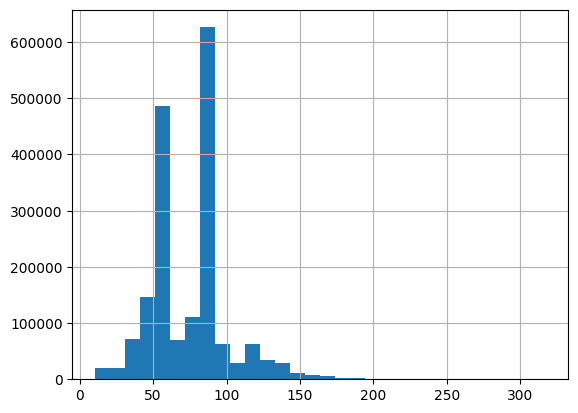

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

train_data['area_m2'].hist(bins=30)

<Axes: >

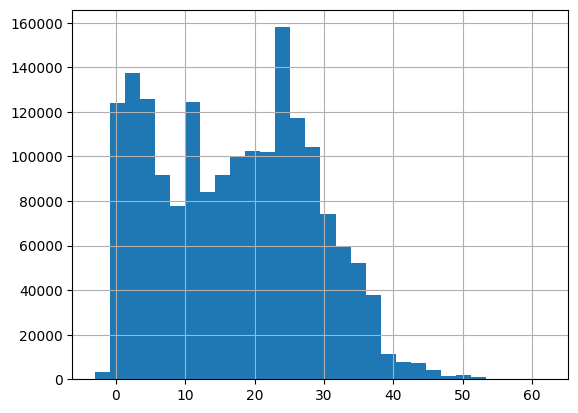

In [19]:
train_data['age'].hist(bins=30)

In [35]:
train_data['log_deposit'] = np.log1p(train_data['deposit'])

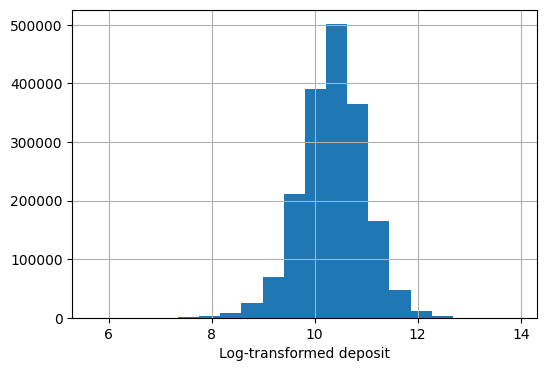

In [36]:
train_data['log_deposit'].hist(bins=20, figsize=(6, 4))
plt.xlabel('Log-transformed deposit')
plt.show()

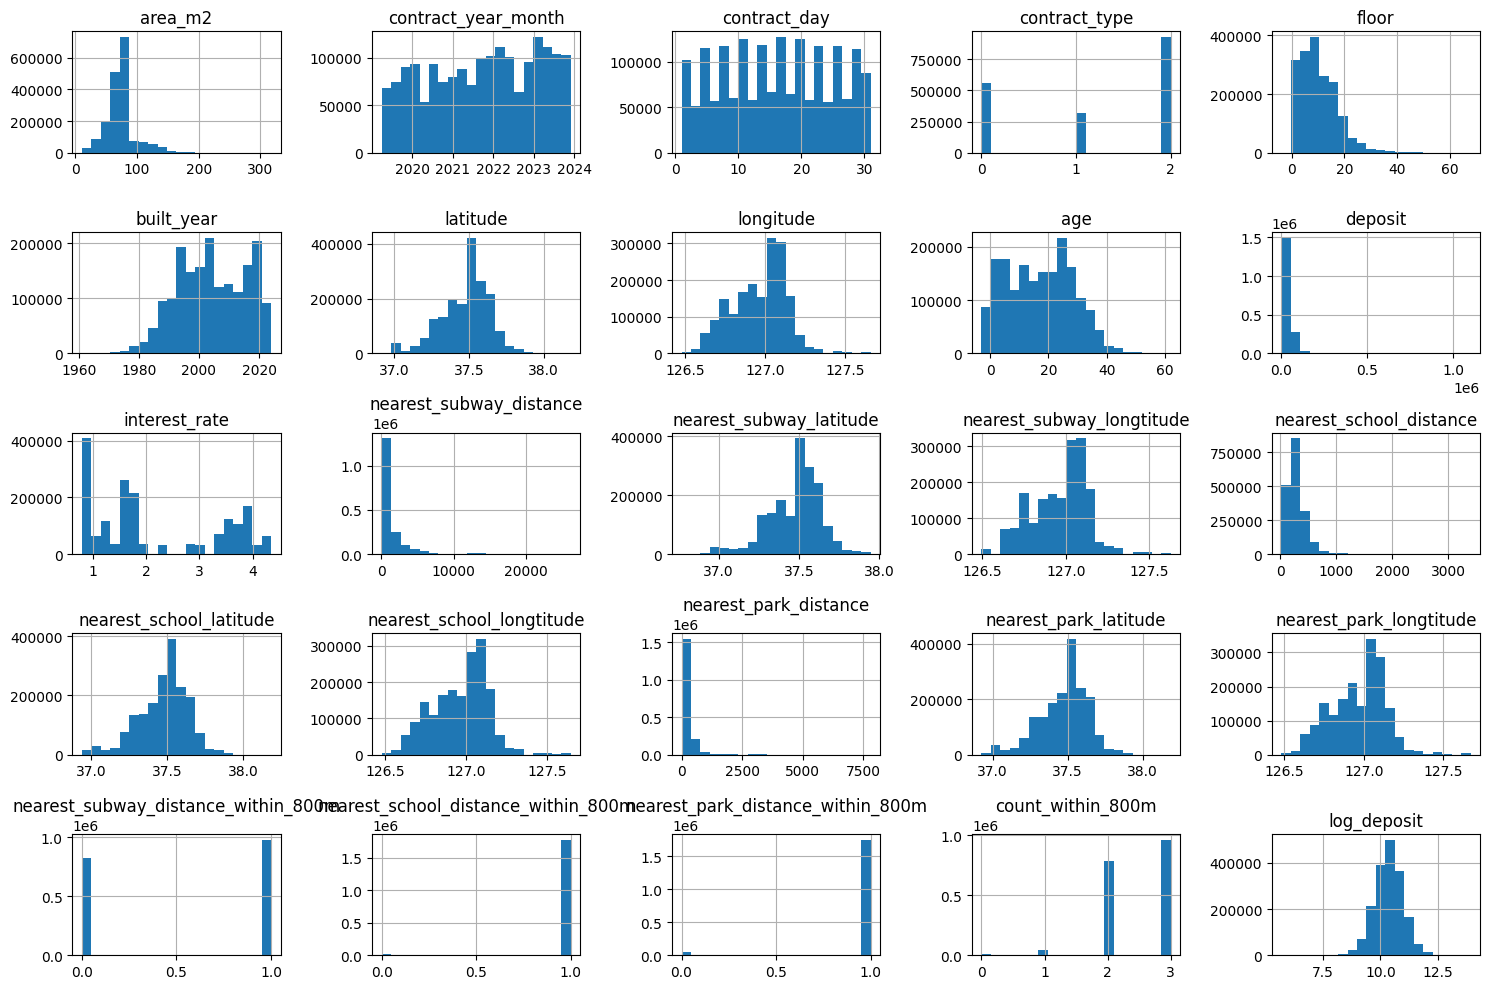

In [37]:
train_data.hist(bins=20, figsize=(15, 10))
plt.tight_layout()
plt.show()

- skewed 변수 : deposit, nearest~distance 변수 -> log 변환필요/ 이상치 

### 변수 간 상관관계

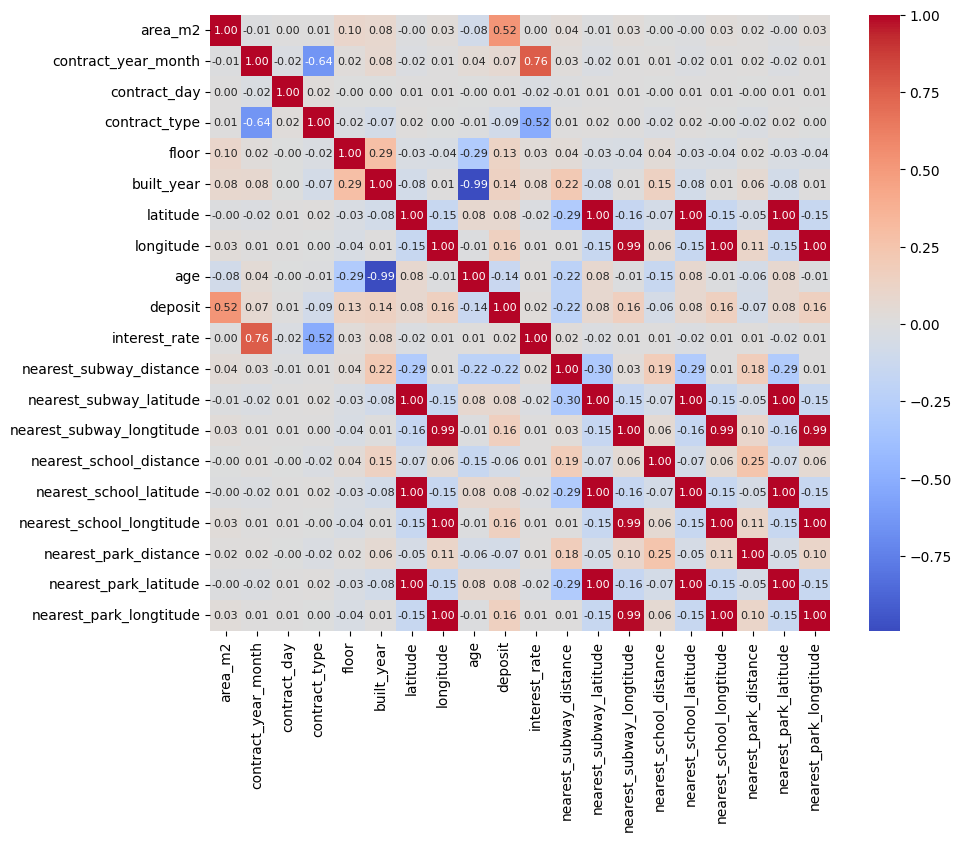

In [20]:
plt.figure(figsize=(10,8))
sns.heatmap(train_data.corr(), annot=True, cmap='coolwarm', annot_kws={"size":8}, fmt='.2f')
plt.show()

1. age와 built_year -> 0.99 ; 둘 중 하나만 써도 될 것

2. 위도 경도와 근접 위치 간 상관관계가 1 ; 문제 없는건지 궁금!

=> 괜찮다면, **특정 거리 이내에 있는지 여부**?(이산화된 변수)

3. deposit(타겟) 과 area_m2 -> 0.52 ; 면적이 클수록 deposit이 증가

    => **area_m2을 범주화**해서 파생변수 생성 ?

### Scatter Plot

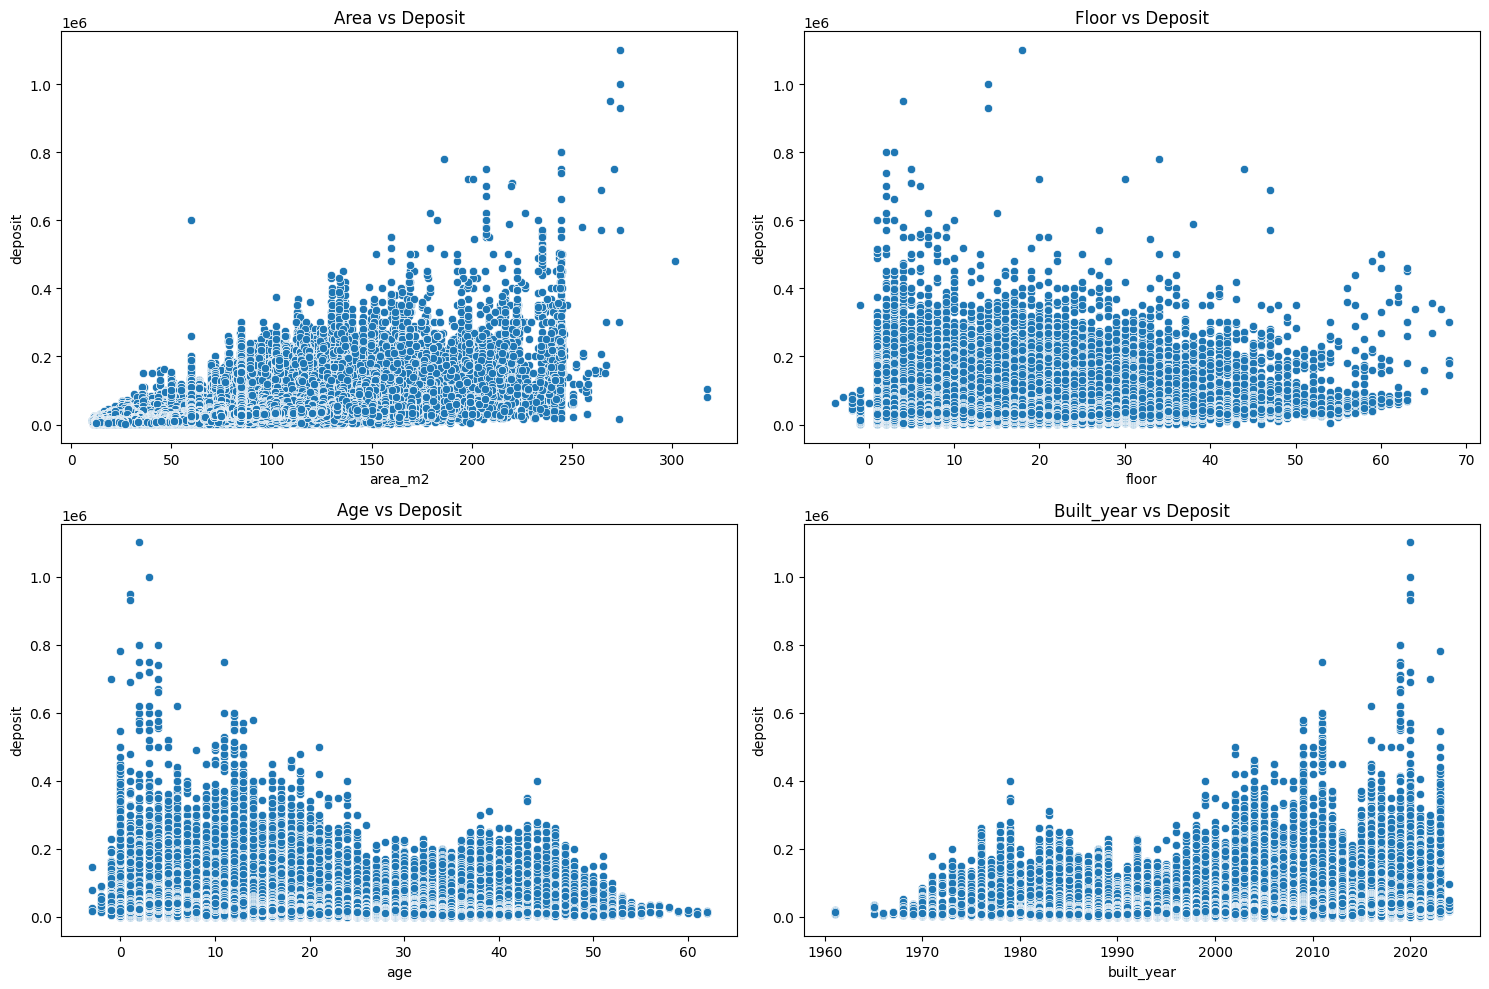

In [21]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

sns.scatterplot(x='area_m2', y='deposit', data=train_data, ax=axs[0, 0])
axs[0,0].set_title('Area vs Deposit')

sns.scatterplot(x='floor', y='deposit', data=train_data, ax=axs[0, 1])
axs[0,1].set_title('Floor vs Deposit')

sns.scatterplot(x='age', y='deposit', data=train_data, ax=axs[1, 0])
axs[1,0].set_title('Age vs Deposit')

sns.scatterplot(x='built_year', y='deposit', data=train_data, ax=axs[1, 1])
axs[1,1].set_title('Built_year vs Deposit')

plt.tight_layout()
plt.show()

1. 면적이 클수록 deposit이 높아지는 경향

2. 층수 - 뚜렷한 패턴 X (보통 높을수록 가격 높아지지 않나?)

3. 건물의 나이가 적을수록 deposit이 높아지는 경향 

4. 최근에 지어진 건물일 수록 deposit이 높음

#### 거리 변수

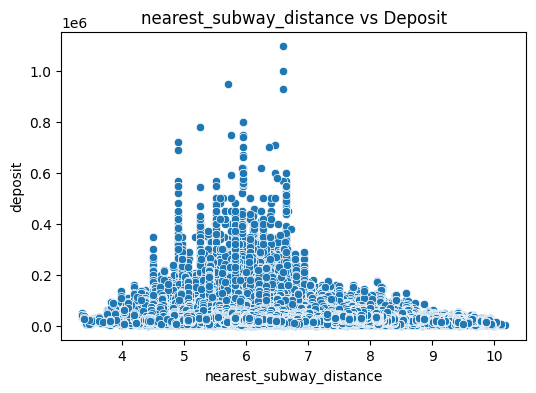

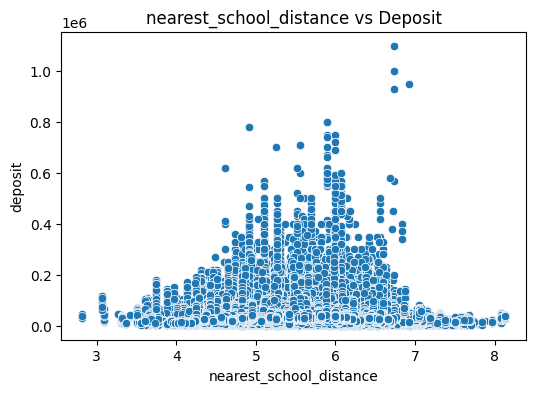

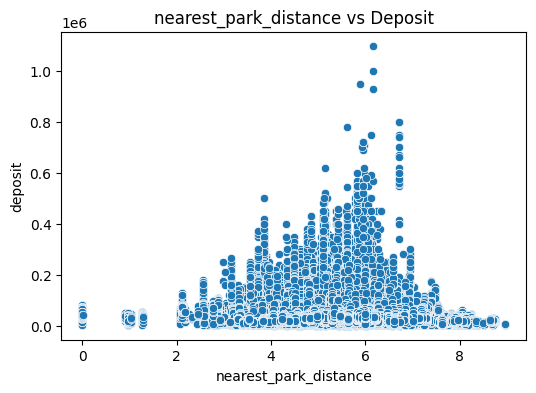

In [22]:
distance_columns = ['nearest_subway_distance', 'nearest_school_distance', 'nearest_park_distance']

# 각 거리 변수와 deposit 간의 산점도 시각화
for col in distance_columns:
    plt.figure(figsize=(6, 4))
    #sns.scatterplot(x=train_data[col], y=train_data['deposit'])
    sns.scatterplot(x=np.log1p(train_data[col]), y=train_data['deposit'])
    plt.title(f'{col} vs Deposit')
    plt.show()

#### 특정 거리 이내 여부

In [23]:
# 임계값 설정 (예: 800m 이내 여부)
threshold = 800  # 0.8km

# 각 거리 변수에 대해 이산 변수 생성
for col in distance_columns:
    train_data[f'{col}_within_{threshold}m'] = (train_data[col] <= threshold).astype(int)

# 결과 확인
print(train_data[[f'{col}_within_{threshold}m' for col in distance_columns]].head())


   nearest_subway_distance_within_800m  nearest_school_distance_within_800m  \
0                                    1                                    1   
1                                    1                                    1   
2                                    1                                    1   
3                                    0                                    1   
4                                    0                                    0   

   nearest_park_distance_within_800m  
0                                  1  
1                                  1  
2                                  1  
3                                  1  
4                                  1  


In [24]:
# 이산화된 변수와 deposit 간의 상관관계 분석
binary_distance_columns = [f'{col}_within_{threshold}m' for col in distance_columns]
correlation_with_deposit_binary = train_data[binary_distance_columns + ['deposit']].corr()['deposit'].drop('deposit')
print(correlation_with_deposit_binary)


nearest_subway_distance_within_800m    0.236374
nearest_school_distance_within_800m    0.066946
nearest_park_distance_within_800m      0.072530
Name: deposit, dtype: float64


In [25]:
# 상호작용 변수 생성
train_data['count_within_800m'] = (
    train_data['nearest_subway_distance_within_800m'] +
    train_data['nearest_school_distance_within_800m'] +
    train_data['nearest_park_distance_within_800m']
).astype(int)

# 결과 확인
print(train_data)

          area_m2  contract_year_month  contract_day  contract_type  floor  \
0         84.9981               201906            25              2      9   
1         84.9981               202003            26              2     20   
2         84.9981               202003            28              2      8   
3         59.3400               201907            15              2      1   
4         59.8100               201904            12              2      6   
...           ...                  ...           ...            ...    ...   
1801223  114.8126               202311            25              0      5   
1801224  101.9088               202311            28              0      6   
1801225  114.7900               202312             3              0     19   
1801226  101.9088               202312             4              1     15   
1801227  114.7900               202312            16              0     10   

         built_year   latitude   longitude  age  deposit  ...  

In [26]:
# 상관관계 분석
correlation = train_data[['count_within_800m', 'deposit']].corr()
print(correlation)

                   count_within_800m   deposit
count_within_800m           1.000000  0.241817
deposit                     0.241817  1.000000


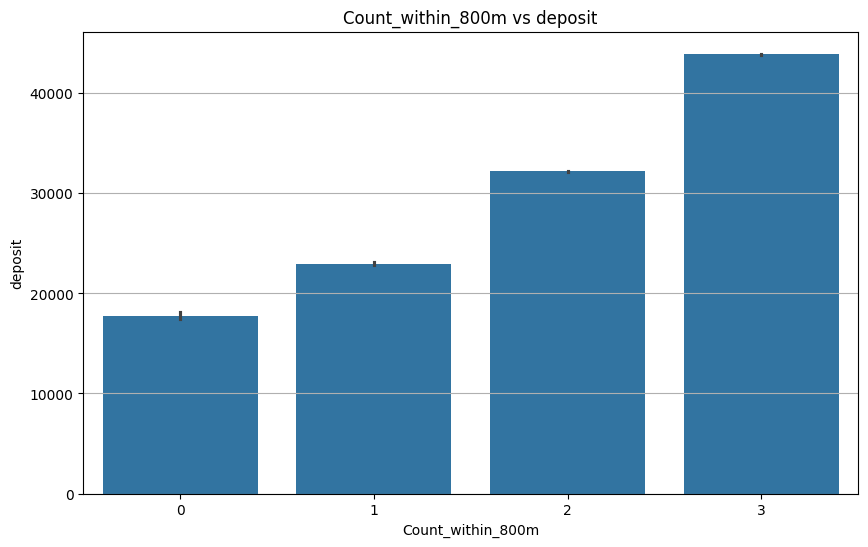

In [27]:
plt.figure(figsize=(10, 6))
sns.barplot(x='count_within_800m', y='deposit', data=train_data)
plt.title('Count_within_800m vs deposit')
plt.xlabel('Count_within_800m')
plt.ylabel('deposit')
plt.grid(axis='y')
plt.show()

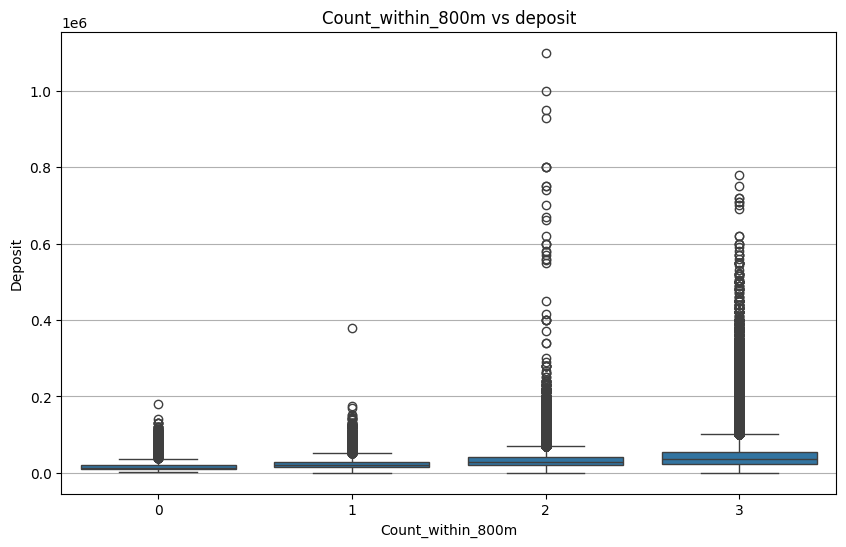

In [28]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='count_within_800m', y='deposit', data=train_data)
plt.title('Count_within_800m vs deposit')
plt.xlabel('Count_within_800m')
plt.ylabel('Deposit')
plt.grid(axis='y')
plt.show()

### 시간에 따른 패턴 분석

<Axes: xlabel='contract_year_month'>

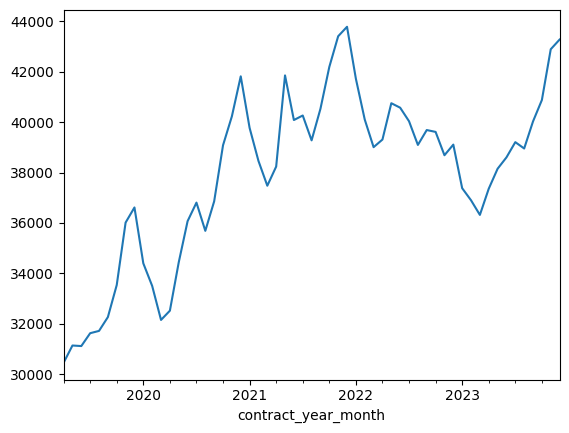

In [29]:
train_data['contract_year_month'] = pd.to_datetime(train_data['contract_year_month'], format='%Y%m')
train_data.groupby('contract_year_month')['deposit'].mean().plot()

- 2019 ~ 2023까지 deposit의 평균값이 전반적으로 상승
- 2022년의 변동성 : 부동산 규제 완화, 금리 인상, 수요 감소..?
>> 금리 인상-> interest_rate 와 추세 비교
[ interest_rate *5000+30000 -> 스케일 임의 조정 ]

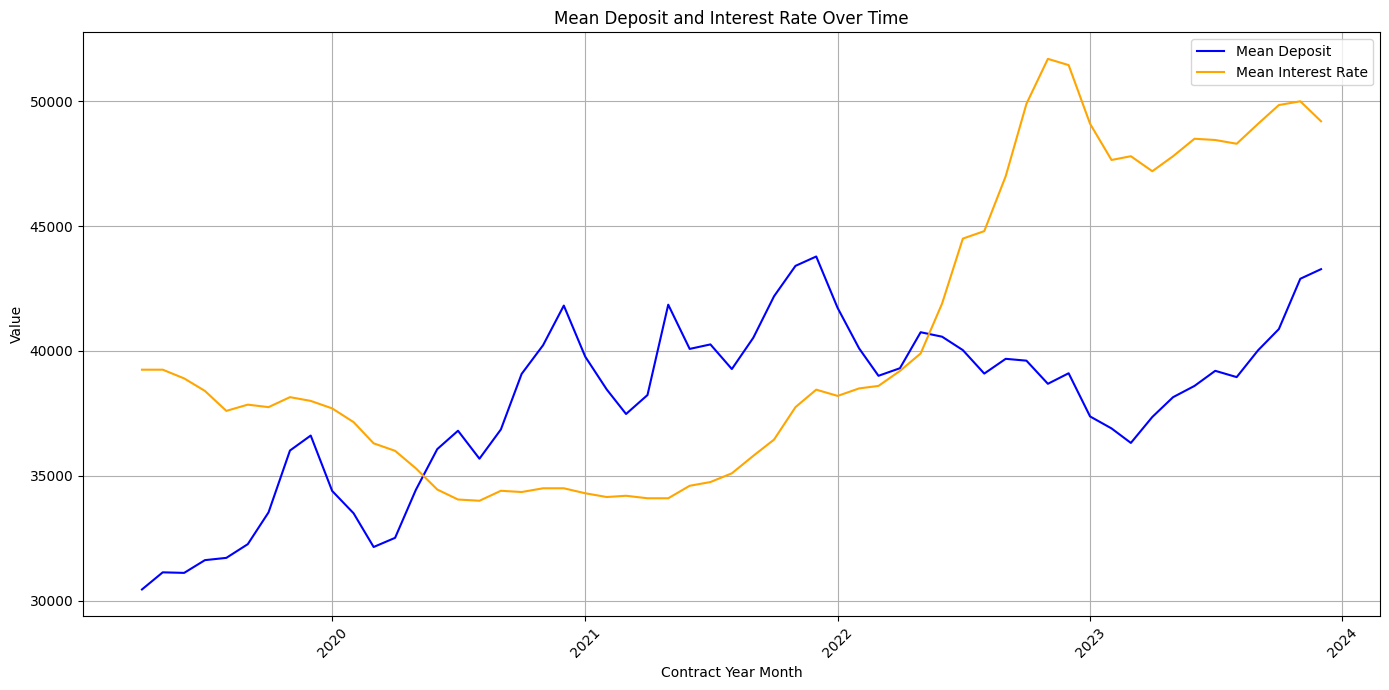

In [30]:
# 평균 deposit과 interest_rate 계산
mean_data = train_data.groupby('contract_year_month').agg({
    'deposit': 'mean',
    'interest_rate': 'mean'
}).reset_index()

# 시각화
plt.figure(figsize=(14, 7))
plt.plot(mean_data['contract_year_month'], mean_data['deposit'], label='Mean Deposit', color='blue')
plt.plot(mean_data['contract_year_month'], mean_data['interest_rate'] * 5000 + 30000, label='Mean Interest Rate', color='orange')

# 플롯 설정
plt.title('Mean Deposit and Interest Rate Over Time')
plt.xlabel('Contract Year Month')
plt.ylabel('Value')
plt.legend()
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()

### area_m2 변수 활용

In [31]:
print(train_data['area_m2'].min())
print(train_data['area_m2'].max())

10.3215
317.36


/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


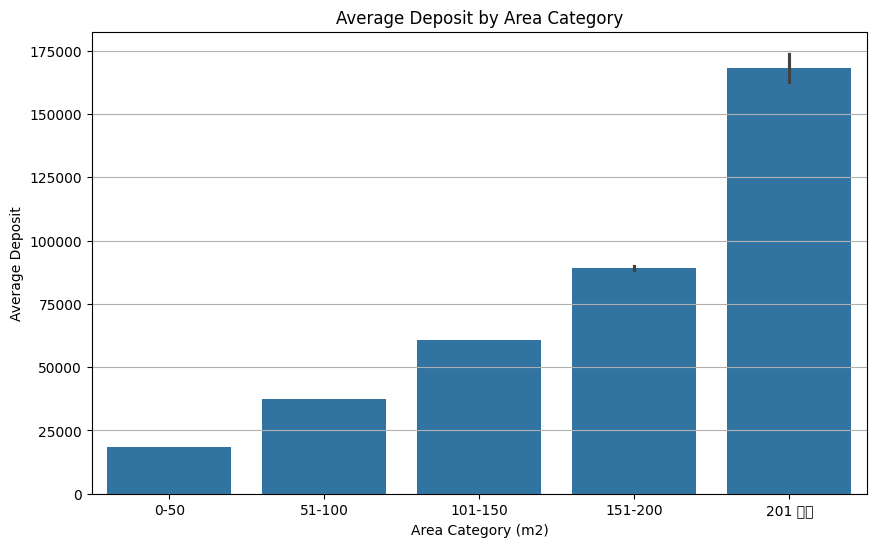

In [32]:
# area_m2를 범주화하여 임시 변수 생성
bins = [0, 50, 100, 150, 200, float('inf')]  # 범주 구간 설정
labels = ['0-50', '51-100', '101-150', '151-200', '201 이상']
area_category = pd.cut(train_data['area_m2'], bins=bins, labels=labels, right=False)

# 범주화된 변수와 deposit 간의 평균 관계 시각화
plt.figure(figsize=(10, 6))
sns.barplot(x=area_category, y='deposit', data=train_data, estimator=lambda x: sum(x) / len(x))
plt.title('Average Deposit by Area Category')
plt.xlabel('Area Category (m2)')
plt.ylabel('Average Deposit')
plt.grid(axis='y')
plt.show()

/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


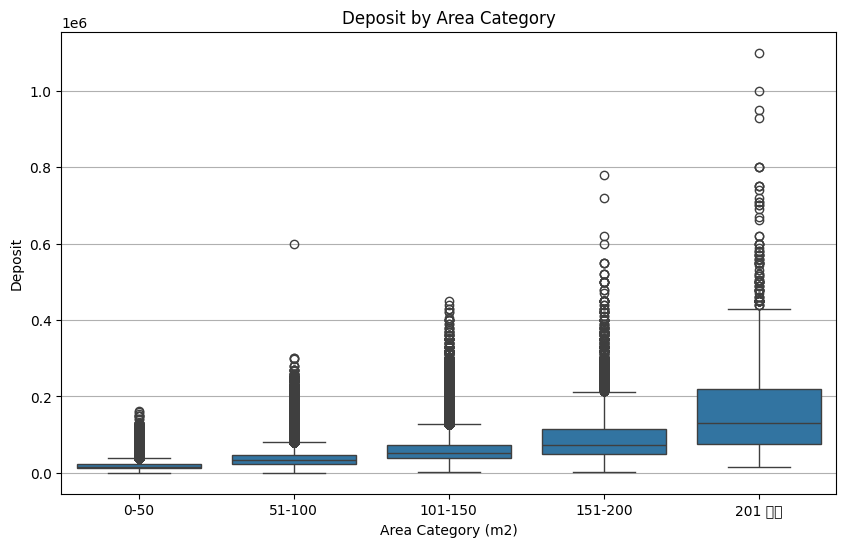

In [33]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=area_category, y='deposit', data=train_data)
plt.title('Deposit by Area Category')
plt.xlabel('Area Category (m2)')
plt.ylabel('Deposit')
plt.grid(axis='y')
plt.show()